Импортируем нужные библиотеки и загрузим датасет

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
df = pd.read_csv('datasets/loyalty.csv', encoding='windows-1251')

In [4]:
df.head()

,Unnamed: 0,tk,pl,dia,hs,tc,cta,id_art,id_subsubfam,id_subfam,...,id_famn,id_seccion,id_subagr,id_agr,vta,uni,id_artn,art_sp,fam_sp,fam_en
0,1242,120071109002055793,1,2007/11/09,0.505729,110000761,11000076,21895,101070640100,1010706401,...,10107064,10107,101,1,0.68,1.0,21895,MARAVILLA 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
1,1243,120070601004053633,1,2007/06/01,0.588519,110000761,11000076,21816,101070640100,1010706401,...,10107064,10107,101,1,0.38,1.0,21816,FIDEO CABELLIN 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
2,1244,120070928004076410,1,2007/09/28,0.785498,28491841,2849184,562840,101070640100,1010706401,...,10107064,10107,101,1,1.55,2.0,562840,SPAGUETTI Nє 5 500 G Brand_1,PASTA ALIMENTICIA SE,pasta
3,1245,120070616003074261,1,2007/06/16,0.550961,95931501,9593150,28914,101070640100,1010706401,...,10107064,10107,101,1,1.03,2.0,28914,FIDEO FIDEUБ 500 Brand_7,PASTA ALIMENTICIA SE,pasta
4,1246,120070519001018477,1,2007/05/19,0.804954,93265591,9326559,159867,101070640100,1010706401,...,10107064,10107,101,1,1.09,1.0,159867,MACARRONES GRATINAR 5 Brand_2,PASTA ALIMENTICIA SE,pasta


В новый датасет запишем только нужные колонки с идентификатором пользователя и брендом пасты

In [5]:
user_df = df[['tc', 'art_sp']]

In [6]:
user_df.head()

,tc,art_sp
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2


Подготовим данные для удобной работы. Переименуем колонки

In [7]:
user_df = user_df.rename(columns={'tc': 'user_id', 'art_sp': 'brand_info'})

In [8]:
user_df.head()

,user_id,brand_info
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2


Выделим из строки brand_info только название самого бренда

In [11]:
def split_brand(brand_name):
    return brand_name.split(' ')[-1]

user_df['brand_name'] = user_df.brand_info.apply(split_brand)

# user_df['brand_name'] = user_df.brand_info.apply(lambda x: x.split(' ')[-1])  Другой вариант без использования функции split_brand

In [12]:
user_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


Выясним, сколько покупок совершил каждый пользователь

In [13]:
users_purchases = user_df.groupby('user_id', as_index=False).agg({'brand_name': 'count'}).rename(columns={'brand_name': 'purchases'})

In [14]:
users_purchases.head()

,user_id,purchases
0,-1236394515,1
1,1031,6
2,4241,5
3,17311,2
4,17312,2


In [16]:
users_purchases.describe()

,user_id,purchases
count,1.176400e+04,11764.000000
mean,7.690517e+07,4.091210
std,1.622210e+08,4.573143
min,-1.236395e+09,1.000000
25%,1.503761e+07,1.000000
50%,4.682179e+07,2.000000
75%,9.311601e+07,5.000000
max,1.408849e+09,60.000000


Медиана равна двум, то есть половина пользователей совершила больше 2 покупок.  
Так как 75-процентиль = 5, то 25% пользователей сделали больше 5 покупок. Проанализируем именно этих пользователей

Запишем в первую таблицу только пользователей, совершивших больше 5 покупок включительно

In [20]:
users_purchases = users_purchases.query('purchases >= 5')
users_purchases.head()

,user_id,purchases
1,1031,6
2,4241,5
11,25971,7
14,40911,27
16,45181,5


Запишем во вторую таблицу пользователей и бренд, продукцию которого они покупают чаще всего, чтобы узнать, какая доля от всех покупок пользователя приходится на продукцию бренда, которую он выбирал чаще всего

In [21]:
users_fav_purchases = user_df.groupby(['user_id', 'brand_name'], as_index=False) \
        .agg({'brand_info': 'count'}) \
        .sort_values(['user_id', 'brand_info'], ascending=[True, False]) \
        .groupby('user_id') \
        .head(1) \
        .rename(columns={'brand_name': 'fav_brand', 'brand_info': 'fav_brand_purchases'})
users_fav_purchases.head()

,user_id,fav_brand,fav_brand_purchases
0,-1236394515,Brand_4,1
2,1031,Store_Brand,5
3,4241,Brand_4,3
5,17311,Brand_4,2
6,17312,Brand_1,1


Запишем в третью таблицу пользователей и количество покупок уникального бренда

In [22]:
users_unique_brands = user_df.groupby('user_id', as_index=False).agg({'brand_name': pd.Series.nunique}).rename(columns={'brand_name': 'unique_brands'})
users_unique_brands.head()

,user_id,unique_brands
0,-1236394515,1
1,1031,2
2,4241,2
3,17311,1
4,17312,2


Объединим три таблицы в одну

In [23]:
loyalty_df = users_purchases \
    .merge(users_unique_brands, on='user_id') \
    .merge(users_fav_purchases, on='user_id')
loyalty_df.head()

,user_id,purchases,unique_brands,fav_brand,fav_brand_purchases
0,1031,6,2,Store_Brand,5
1,4241,5,2,Brand_4,3
2,25971,7,2,Store_Brand,5
3,40911,27,5,Brand_4,19
4,45181,5,4,Store_Brand,2


Отберём покупателей, которые совершили покупки только одного бренда. Они являются лояльными покупателями

In [26]:
loyal_users = loyalty_df[loyalty_df.unique_brands == 1]
loyal_users.head()

,user_id,purchases,unique_brands,fav_brand,fav_brand_purchases
13,86281,14,1,Brand_4,14
18,94961,6,1,Brand_4,6
29,132061,9,1,Brand_4,9
30,134281,6,1,Brand_4,6
35,157311,12,1,Brand_4,12


Для всех остальных покупателей придумаем метрику, которая будет отличать лояльных покупателей от обычных.  
Пусть это будет доля покупок бренда, который они выбирали чаще всего, среди всех покупок

In [29]:
loyalty_df['loyalty_score'] = loyalty_df.fav_brand_purchases / loyalty_df.purchases
loyalty_df

,user_id,purchases,unique_brands,fav_brand,fav_brand_purchases,loyalty_score
0,1031,6,2,Store_Brand,5,0.833333
1,4241,5,2,Brand_4,3,0.600000
2,25971,7,2,Store_Brand,5,0.714286
3,40911,27,5,Brand_4,19,0.703704
4,45181,5,4,Store_Brand,2,0.400000
...,...,...,...,...,...,...
3378,1408767189,5,1,Brand_4,5,1.000000
3379,1408783189,10,2,Store_Brand,8,0.800000
3380,1408783379,6,2,Brand_1,4,0.666667
3381,1408798879,8,3,Store_Brand,4,0.500000


Построим график распределения новой метрики

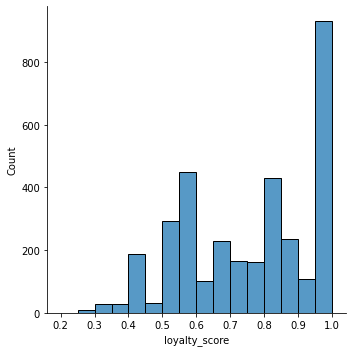

In [47]:
ax = sns.displot(loyalty_df.loyalty_score)

Отберём пользователей, у которых метрика лояльности равна 0.8 и выше

In [32]:
loyal_users = loyalty_df[loyalty_df.loyalty_score >= 0.8]
loyal_users.head()

,user_id,purchases,unique_brands,fav_brand,fav_brand_purchases,loyalty_score
0,1031,6,2,Store_Brand,5,0.833333
5,63001,8,2,Brand_4,7,0.875000
8,69371,14,2,Brand_4,12,0.857143
13,86281,14,1,Brand_4,14,1.000000
15,93631,10,2,Brand_4,8,0.800000


In [33]:
loyal_users.shape[0]

1703

1703 покупателя из 11764 попадают в программу лояльности и получат скидку на товар своего любимого бренда

Проведём дополнительный анализ и определим для каждого бренда медианную метрику лояльности и количество покупателей

In [36]:
brand_loyalty = loyalty_df.groupby('fav_brand', as_index=False).agg({'loyalty_score': 'median', 'user_id': 'count'})
brand_loyalty

,fav_brand,loyalty_score,user_id
0,Brand_1,0.679487,410
1,Brand_2,0.600000,88
2,Brand_3,0.500000,115
3,Brand_4,0.818182,2041
4,Brand_5,0.600000,5
5,Brand_7,0.444444,9
6,Store_Brand,0.750000,715


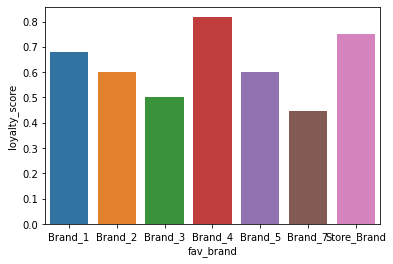

In [40]:
ax = sns.barplot(x='fav_brand', y='loyalty_score', data=brand_loyalty)

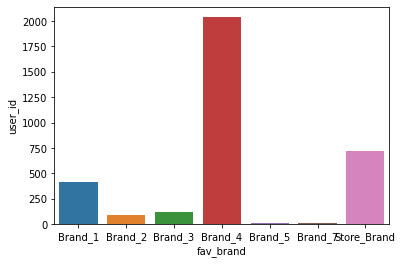

In [39]:
ax = sns.barplot(x='fav_brand', y='user_id', data=brand_loyalty)

У бренда 4 самая высокая метрика лояльности, и большинство покупателей - это лояльные покупатели этого бренда 